In [1]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from wmpgnn.datasets.hetero_graph_dataset import CustomHeteroDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add
from wmpgnn.performance.reconstruction import reconstruct_decay

In [2]:
from wmpgnn.model.gnn_model import GNN
from wmpgnn.model.model_loader import ModelLoader
from wmpgnn.configs.config_loader import ConfigLoader
from wmpgnn.datasets.data_handler import DataHandler
# Load the configuration
config_loader = ConfigLoader("config_files/heteromp_gnn_inference_B_DD.yaml", environment_prefix="DL")
#config_loader = ConfigLoader("config_files/mp_gnn_inference.yaml", environment_prefix="DL")

In [3]:
config_loader.get('dataset')

{'data_type': 'heterogeneous',
 'data_dir': '/home/sutclw/weighted_MP_gnn/full_graphs_B_DD'}

In [4]:
from wmpgnn.performance.performance import Performance

In [5]:
perf = Performance(config_loader)

/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(

0


/home/sutclw/Work/Zurich/LHCb/GNNs/weighted_MP_gnn/wmpgnn/performance/performance.py:629: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.event_df = self.event_df._append({'EventNumber': event,


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

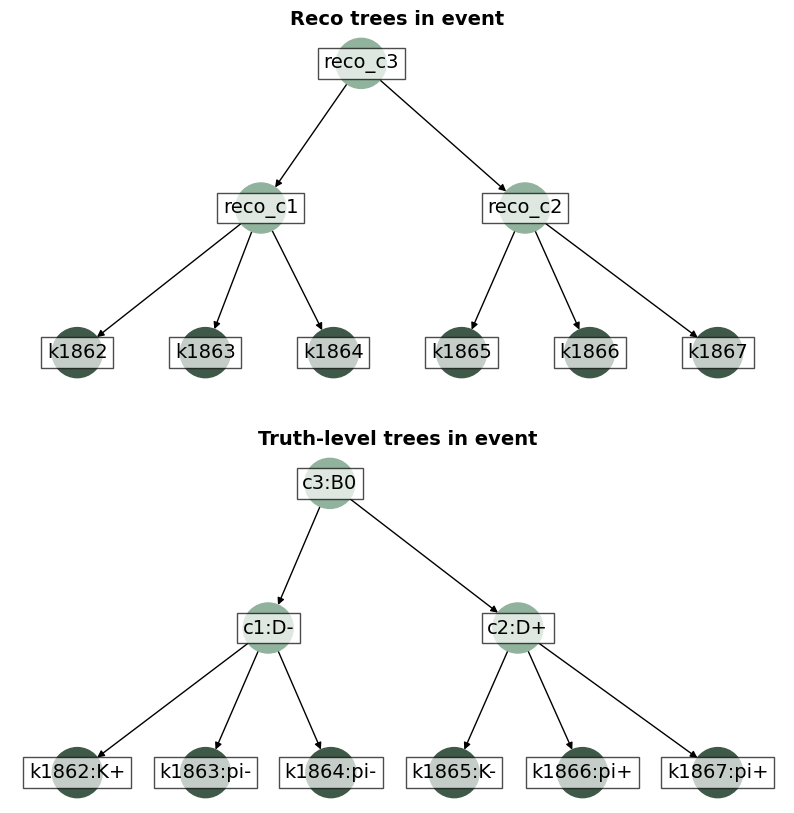

In [6]:
perf.evaluate_reco_performance(event_max=1000,pruning_cut=0.2,plot_perfect_decaychains=20)

In [8]:
perf.model.cuda()

HeteroGNN(
  (_encoder): HeteroGraphCoder(
    (_global_model): WrappedModelFnModule(
      (_model): MLP(-1, 128, 128, 128, 16)
    )
    (_edge_models_model_dict): ModuleDict(
      (('tracks', 'to', 'tracks')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (('tracks', 'to', 'pvs')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
    (_node_models_model_dict): ModuleDict(
      (tracks): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (pvs): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_blocks): ModuleList(
    (0-7): 8 x HeteroGraphNetwork(
      (_edge_block): HeteroEdgeBlock(
        (_edge_models_model_dict): ModuleDict(
          (('tracks', 'to', 'tracks')): MLP(-1, 128, 128, 128, 16)
          (('tracks', 'to', 'pvs')): MLP(-1, 128, 128, 128, 16)
        )
      )
      (_node_block): HeteroNodeBlock(
        (_received_edges_aggregat

In [9]:
for i,vdata in enumerate(perf.dataset):
    vdata_copy = vdata.clone()
    vdata.cuda()
    vdata

    gout = perf.model(vdata)
    gout.cpu()
    vdata.cpu()
    reco_LCA = perf.lca_reco_matrix(gout)
    particle_keys = list(vdata["final_keys"].numpy())
    reco_cluster_dict, reco_num_clusters_per_order, _ = reconstruct_decay(
    reco_LCA, particle_keys)
    if i ==1:
        break

In [10]:
#reco_cluster_dict

In [11]:
#reco_cluster_dict

In [12]:
node_keys = reco_cluster_dict[1862]['node_keys']

In [13]:
node_keys

[1862, 1863, 1864, 1865, 1866, 1867]

In [14]:
vdata['pvs'].x.shape

torch.Size([6, 16])

In [15]:
import matplotlib.pyplot as plt

In [16]:
ind1= (node_keys[0]==vdata_copy.final_keys) | (node_keys[1]==vdata_copy.final_keys) | (node_keys[2]==vdata_copy.final_keys) | (node_keys[3]==vdata_copy.final_keys) | (node_keys[4]==vdata_copy.final_keys) | (node_keys[5]==vdata_copy.final_keys) 

In [17]:
ind1= (node_keys[0]==vdata_copy.final_keys) | (node_keys[1]==vdata_copy.final_keys) | (node_keys[2]==vdata_copy.final_keys) | (node_keys[3]==vdata_copy.final_keys) | (node_keys[4]==vdata_copy.final_keys) | (node_keys[5]==vdata_copy.final_keys) 

In [18]:
#x = vdata_copy["tracks"].x[:,:3].numpy()

In [19]:
x = vdata_copy["tracks"].x[:,:3].numpy()
p = vdata_copy["tracks"].x[:,3:6].numpy()
xB = vdata_copy["tracks"].x[ind1,:3].numpy()
pB = vdata_copy["tracks"].x[ind1,3:6].numpy()

In [20]:
p_norm = p / np.sqrt(np.sum(p**2))

In [21]:
p_normB = pB / np.sqrt(np.sum(pB**2))

In [22]:
p_norm.shape

(145, 3)

In [23]:
x.shape

(145, 3)

In [24]:
track_ids = gout[('tracks','to','pvs')].edge_index[0][(perf.model._blocks[-1].edge_weights[('tracks','to','pvs')] >0.5).squeeze(1).cpu()]
pv_ids = gout[('tracks','to','pvs')].edge_index[1][(perf.model._blocks[-1].edge_weights[('tracks','to','pvs')] >0.5).squeeze(1).cpu()]

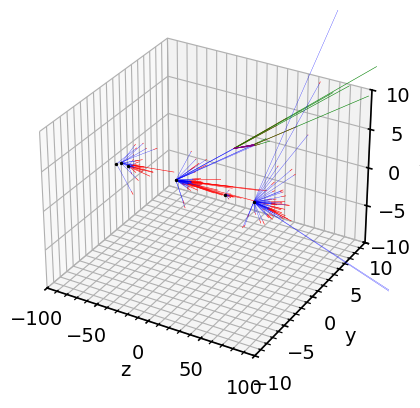

In [39]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
for i in range(x.shape[0]):
    vector = []
    for k in np.linspace(0,200,2):
        vector.append(x[i,:]+ k*p_norm[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    ax.plot3D(zline, yline, xline, 'red', linewidth=0.4)

for i in range(xB.shape[0]):
    vector = []
    for k in np.linspace(0,200,2):
        vector.append(xB[i,:]+ k*p_normB[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    ax.plot3D(zline, yline, xline, 'green', linewidth=0.4)


for i in range(track_ids.shape[0]):
    v = []
    v.append(vdata_copy['tracks'].x[track_ids[i],:3].numpy())
    v.append(vdata_copy['pvs'].x[pv_ids[i],:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    # ax.set_ylim(bottom=-5,top=5)
    # ax.set_zlim(bottom=-100,top=100)
    # ax.set_xlim(left=-5,right=5)    
    ax.plot3D(zline, yline, xline, 'blue', linewidth=0.2)

for i in range(gout[('tracks','to','tracks')].edge_index.shape[1]):
    v = []
    v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[0][i],:3].numpy())
    v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[1][i],:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    if i==0:
        ax.plot3D(zline, yline, xline, 'purple', linewidth=0.2)
    else:
        ax.plot3D(zline, yline, xline, 'purple', linewidth=0.2)

ax.set_ylim(bottom=-10,top=10)
# ax.scatter3D(v2[0,ind],v2[1,ind],v2[2,ind])
ax.set_zlim(bottom=-10,top=10)
ax.set_xlim(left=-100,right=100)    
for i in range(0,vdata['pvs'].x.shape[0]):
    if i==0:
        ax.scatter3D(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item() ,vdata_copy['pvs'].x[i][0].item(), c='black', s=2, label="pvs")
    else:
        ax.scatter3D(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item() ,vdata_copy['pvs'].x[i][0].item(), c='black', s=2)
ax.set_ylabel("y")
ax.set_zlabel("x") 
ax.set_xlabel("z")   

plt.savefig("dfei_event.png",dpi=300)
#ax.legend(loc='upper left')

In [39]:
vdata_copy[('tracks','to','tracks')].edge_index.shape[1]

18564

In [62]:
gout[('tracks','to','tracks')].edge_index

tensor([[48, 49, 50, 51, 52, 49, 50, 51, 52, 50, 51, 52, 51, 52, 52, 47, 47, 47,
         47, 47, 48, 48, 48, 48, 49, 49, 49, 50, 50, 51],
        [47, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 50, 50, 51, 48, 49, 50,
         51, 52, 49, 50, 51, 52, 50, 51, 52, 51, 52, 52]])

In [ ]:
vdata_

In [52]:
vdata

HeteroDataBatch(
  init_senders=[18564],
  init_receivers=[18564],
  init_y=[18564, 4],
  init_keys=[145],
  init_moth_ids=[9282],
  init_partids=[145],
  final_keys=[145],
  moth_ids=[9282],
  part_ids=[145],
  lca_chain=[9282],
  old_y=[0, 4],
  tracks={
    x=[145, 16],
    batch=[145],
    ptr=[2],
  },
  pvs={
    x=[6, 16],
    batch=[6],
    ptr=[2],
  },
  globals={
    x=[1, 16],
    batch=[1],
    ptr=[2],
  },
  (tracks, to, pvs)={
    edge_index=[2, 870],
    y=[870, 1],
    edges=[870, 16],
  },
  (tracks, to, tracks)={
    edge_index=[2, 18564],
    y=[18564, 4],
    edges=[18564, 16],
  }
)

In [60]:
gout.edge_index

AttributeError: 'HeteroDataBatch' has no attribute 'edge_index'

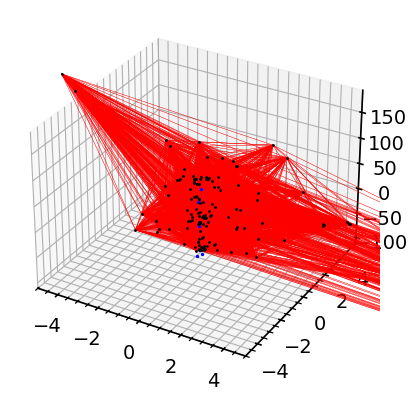

In [71]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
for i in range(x.shape[0]):
    ax.scatter3D(vdata_copy['tracks'].x[i][0].item(),vdata_copy['tracks'].x[i][1].item() ,vdata_copy['tracks'].x[i][2].item(), c='black',s=1)

for i in range(vdata_copy[('tracks','to','tracks')].edge_index.shape[1]):
    v = []
    v.append(vdata_copy['tracks'].x[vdata_copy[('tracks','to','tracks')].edge_index[0][i],:3].numpy())
    v.append(vdata_copy['tracks'].x[vdata_copy[('tracks','to','tracks')].edge_index[1][i],:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    ax.set_ylim(bottom=-5,top=5)
    ax.set_xlim(left=-5,right=5)    
    ax.plot3D(xline, yline, zline, 'red', linewidth=0.2)


for i in range(0,vdata['pvs'].x.shape[0]):
    ax.scatter3D(vdata_copy['pvs'].x[i][0].item(),vdata_copy['pvs'].x[i][1].item() ,vdata_copy['pvs'].x[i][2].item(), c='blue', s=2)

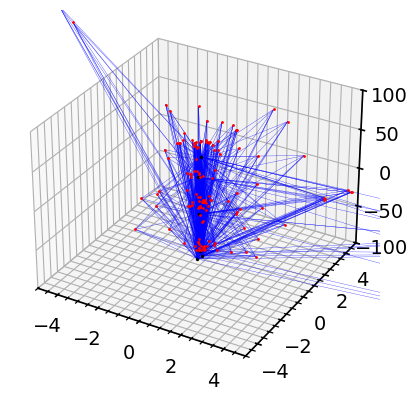

In [78]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
for i in range(x.shape[0]):
    ax.scatter3D(vdata_copy['tracks'].x[i][0].item(),vdata_copy['tracks'].x[i][1].item() ,vdata_copy['tracks'].x[i][2].item(), c='red',s=1)

for i in range(vdata_copy[('tracks','to','pvs')].edge_index.shape[1]):
    v = []
    v.append(vdata_copy['tracks'].x[vdata_copy[('tracks','to','pvs')].edge_index[0][i],:3].numpy())
    v.append(vdata_copy['pvs'].x[vdata_copy[('tracks','to','pvs')].edge_index[1][i],:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    ax.set_ylim(bottom=-5,top=5)
    ax.set_zlim(bottom=-100,top=100)
    ax.set_xlim(left=-5,right=5)    
    ax.plot3D(xline, yline, zline, 'blue', linewidth=0.2)


for i in range(0,vdata['pvs'].x.shape[0]):
    ax.scatter3D(vdata_copy['pvs'].x[i][0].item(),vdata_copy['pvs'].x[i][1].item() ,vdata_copy['pvs'].x[i][2].item(), c='black', s=2)

In [84]:
gout[('tracks','to','pvs')].edge_index[0].shape

torch.Size([870])

In [101]:
(perf.model._blocks[-1].edge_weights[('tracks','to','pvs')] >0.5).shape

torch.Size([870, 1])

In [102]:
track_ids = gout[('tracks','to','pvs')].edge_index[0][(perf.model._blocks[-1].edge_weights[('tracks','to','pvs')] >0.5).squeeze(1).cpu()]
pv_ids = gout[('tracks','to','pvs')].edge_index[1][(perf.model._blocks[-1].edge_weights[('tracks','to','pvs')] >0.5).squeeze(1).cpu()]

In [103]:
track_ids.shape

torch.Size([145])

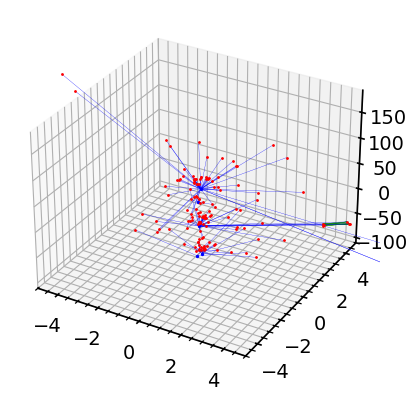

In [116]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
for i in range(x.shape[0]):
    ax.scatter3D(vdata_copy['tracks'].x[i][0].item(),vdata_copy['tracks'].x[i][1].item() ,vdata_copy['tracks'].x[i][2].item(), c='red',s=1)

for i in range(gout[('tracks','to','tracks')].edge_index.shape[1]):
    v = []
    v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[0][i],:3].numpy())
    v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[1][i],:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    
    ax.plot3D(xline, yline, zline, 'green', linewidth=0.2)
    
    ax.set_ylim(bottom=-5,top=5)
    ax.set_xlim(left=-5,right=5)

for i in range(track_ids.shape[0]):
    v = []
    v.append(vdata_copy['tracks'].x[track_ids[i],:3].numpy())
    v.append(vdata_copy['pvs'].x[pv_ids[i],:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    # ax.set_ylim(bottom=-5,top=5)
    # ax.set_zlim(bottom=-100,top=100)
    # ax.set_xlim(left=-5,right=5)    
    ax.plot3D(xline, yline, zline, 'blue', linewidth=0.2)

for i in range(0,vdata['pvs'].x.shape[0]):
    ax.scatter3D(vdata_copy['pvs'].x[i][0].item(),vdata_copy['pvs'].x[i][1].item() ,vdata_copy['pvs'].x[i][2].item(), c='blue', s=2)

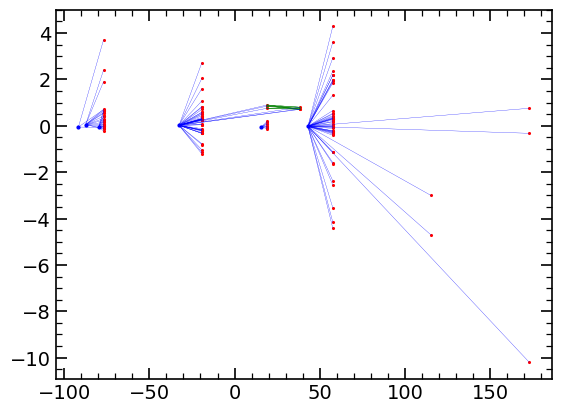

In [115]:
fig = plt.figure()
ax = plt.axes()
# Data for a three-dimensional line
for i in range(x.shape[0]):
    ax.scatter(vdata_copy['tracks'].x[i][2].item(),vdata_copy['tracks'].x[i][1].item() , c='red',s=1.5)

for i in range(gout[('tracks','to','tracks')].edge_index.shape[1]):
    v = []
    v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[0][i],:3].numpy())
    v.append(vdata_copy['tracks'].x[gout[('tracks','to','tracks')].edge_index[1][i],:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    
    ax.plot(zline, yline, 'green', linewidth=0.2)
    
    #ax.set_ylim(bottom=-5,top=5)
    #ax.set_xlim(left=-5,right=5)

for i in range(track_ids.shape[0]):
    v = []
    v.append(vdata_copy['tracks'].x[track_ids[i],:3].numpy())
    v.append(vdata_copy['pvs'].x[pv_ids[i],:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    # ax.set_ylim(bottom=-5,top=5)
    # ax.set_zlim(bottom=-100,top=100)
    # ax.set_xlim(left=-5,right=5)    
    ax.plot(zline, yline, 'blue', linewidth=0.2)

for i in range(0,vdata['pvs'].x.shape[0]):
    ax.scatter(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item(),  c='blue', s=4)

In [57]:
vdata_copy[('tracks','to','tracks')].edge_index.shape

torch.Size([2, 18564])

In [56]:
vdata[('tracks','to','tracks')].edge_index.shape

torch.Size([2, 18564])

In [58]:
vdata

HeteroDataBatch(
  init_senders=[18564],
  init_receivers=[18564],
  init_y=[18564, 4],
  init_keys=[145],
  init_moth_ids=[9282],
  init_partids=[145],
  final_keys=[145],
  moth_ids=[9282],
  part_ids=[145],
  lca_chain=[9282],
  old_y=[0, 4],
  tracks={
    x=[145, 16],
    batch=[145],
    ptr=[2],
  },
  pvs={
    x=[6, 16],
    batch=[6],
    ptr=[2],
  },
  globals={
    x=[1, 16],
    batch=[1],
    ptr=[2],
  },
  (tracks, to, pvs)={
    edge_index=[2, 870],
    y=[870, 1],
    edges=[870, 16],
  },
  (tracks, to, tracks)={
    edge_index=[2, 18564],
    y=[18564, 4],
    edges=[18564, 16],
  }
)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
for i in range(x.shape[0]):
    ax.scatter3D(vdata_copy['tracks'].x[i][0].item(),vdata_copy['tracks'].x[i][1].item() ,vdata_copy['tracks'].x[i][2].item(), c='black',s=1)

for i in range(vdata_copy[('tracks','to','tracks')].edge_index.shape[1]):
    v = []
    v.append(vdata_copy['tracks'].x[vdata_copy[('tracks','to','tracks')].edge_index[0][i],:3].numpy())
    v.append(vdata_copy['tracks'].x[vdata_copy[('tracks','to','tracks')].edge_index[1][i],:3].numpy())
    #print(v)
    v = np.array(v)
    #print(v.shape)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    
    ax.plot3D(xline, yline, zline, 'red')


for i in range(0,vdata['pvs'].x.shape[0]):
    ax.scatter3D(vdata_copy['pvs'].x[i][0].item(),vdata_copy['pvs'].x[i][1].item() ,vdata_copy['pvs'].x[i][2].item(), c='blue', s=2)

In [47]:
#vdata_copy['tracks'].x[vdata_copy[('tracks','to','tracks')].edge_index[0][10],:3].numpy()

array([ -0.39532948,   0.04590057, -19.23077   ], dtype=float32)

In [44]:
v.shape

(40, 3)

In [178]:
vdata['pvs']

{'x': tensor([[-2.2234e+00,  2.1660e+00,  1.3740e+00, -3.6878e+01, -7.4287e-01,
         -3.6745e+00,  4.0028e+00, -4.3296e+00,  9.8907e-01,  4.5234e-01,
          3.3816e+00,  3.7108e+00, -5.7185e+00, -1.0032e+00,  2.6540e+00,
          2.4698e+01],
        [ 1.3509e+00, -1.4870e+00,  2.3327e-01,  1.2307e+00,  1.7347e+00,
         -9.3270e-01,  4.9679e-01, -1.0087e+00,  9.4582e-01,  3.3351e-01,
          2.5458e-01,  1.6449e+00,  3.9670e-01, -9.2427e-01, -3.0580e-01,
         -1.3449e-02],
        [-2.7847e-01, -1.7678e-01, -2.2693e-01, -4.6812e+00,  1.5744e-02,
          6.4295e-01, -6.2462e-01, -7.7074e-02,  3.9484e-01,  1.5970e-01,
          2.6838e+00,  1.8619e+00,  5.1477e-01, -8.7222e-01, -3.2873e-01,
          3.0495e+00],
        [-1.5918e+00,  7.2303e-01,  2.1848e-01, -2.1474e+01, -2.6641e-01,
         -6.4743e-01,  9.7098e-01, -1.7725e+00,  1.1219e+00,  8.1932e-01,
          4.1941e+00,  3.1260e+00, -1.7499e+00, -1.1602e+00,  9.2365e-01,
          1.4323e+01],
        [ 3.72

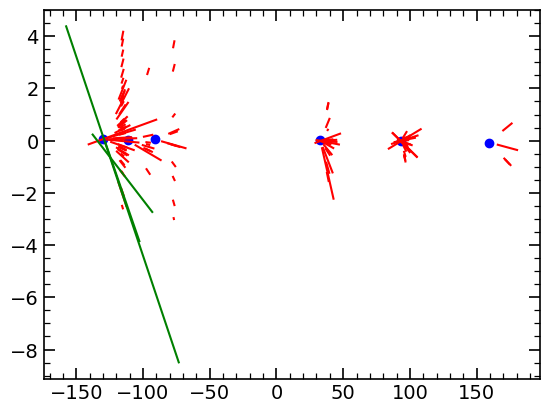

In [202]:
fig = plt.figure()
for i in range(x.shape[0]):
    vector = []
    for k in np.linspace(-50,50,40):
        vector.append(x[i,:]+ k*p_norm[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    plt.plot(zline, yline,  'red')

for i in range(xB.shape[0]):
    vector = []
    for k in np.linspace(-50,50,40):
        vector.append(xB[i,:]+ k*p_normB[i,:])
    v = np.array(vector)
    zline = v[:,2]
    xline = v[:,0]
    yline = v[:,1]
    plt.plot(zline, yline,  'green')
for i in range(0,vdata_copy['pvs'].x.shape[0]):
    plt.scatter(vdata_copy['pvs'].x[i][2].item(),vdata_copy['pvs'].x[i][1].item(), c='blue')
plt.show()